### Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/[2023-2024] AN2DL/Lecture 7

### Import libraries

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

### Load and process data

In [ ]:
column_names = ['user_id', 'activity', 'timestamp', 'x_axis', 'y_axis', 'z_axis']

df = pd.read_csv('activities.txt', header=None, names=column_names)
df.dropna(axis=0, how='any', inplace=True)

In [ ]:
print(df.shape)
df.head(10)

(1098208, 6)


,user_id,activity,timestamp,x_axis,y_axis,z_axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164
5,33,Jogging,49106442306000,1.375655,-2.492524,-6.510526
6,33,Jogging,49106542312000,-0.612916,10.569390,5.706926
7,33,Jogging,49106652389000,-0.503953,13.947236,7.055340
8,33,Jogging,49106762313000,-8.430995,11.413852,5.134871
9,33,Jogging,49106872299000,0.953424,1.375655,1.648062


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1098208 entries, 0 to 1098208
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user_id    1098208 non-null  int64  
 1   activity   1098208 non-null  object 
 2   timestamp  1098208 non-null  int64  
 3   x_axis     1098208 non-null  float64
 4   y_axis     1098208 non-null  float64
 5   z_axis     1098208 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 58.7+ MB


In [ ]:
df['x_axis'] = df['x_axis'].astype(np.float32)
df['y_axis'] = df['y_axis'].astype(np.float32)
df['z_axis'] = df['z_axis'].astype(np.float32)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1098208 entries, 0 to 1098208
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user_id    1098208 non-null  int64  
 1   activity   1098208 non-null  object 
 2   timestamp  1098208 non-null  int64  
 3   x_axis     1098208 non-null  float32
 4   y_axis     1098208 non-null  float32
 5   z_axis     1098208 non-null  float32
dtypes: float32(3), int64(2), object(1)
memory usage: 46.1+ MB


In [ ]:
df.describe()

,user_id,timestamp,x_axis,y_axis,z_axis
count,1.098208e+06,1.098208e+06,1.098208e+06,1.098208e+06,1.098208e+06
mean,1.886067e+01,3.340895e+13,6.628657e-01,7.255626e+00,4.110785e-01
std,1.021423e+01,4.944962e+13,6.849046e+00,6.746216e+00,4.754120e+00
min,1.000000e+00,0.000000e+00,-1.961000e+01,-1.961000e+01,-1.980000e+01
25%,1.000000e+01,2.019110e+12,-2.870000e+00,3.170000e+00,-2.220000e+00
50%,1.900000e+01,9.722677e+12,2.700000e-01,7.930000e+00,0.000000e+00
75%,2.800000e+01,4.996560e+13,4.440000e+00,1.156000e+01,2.720000e+00
max,3.600000e+01,2.093974e+14,1.995000e+01,2.004000e+01,1.961000e+01


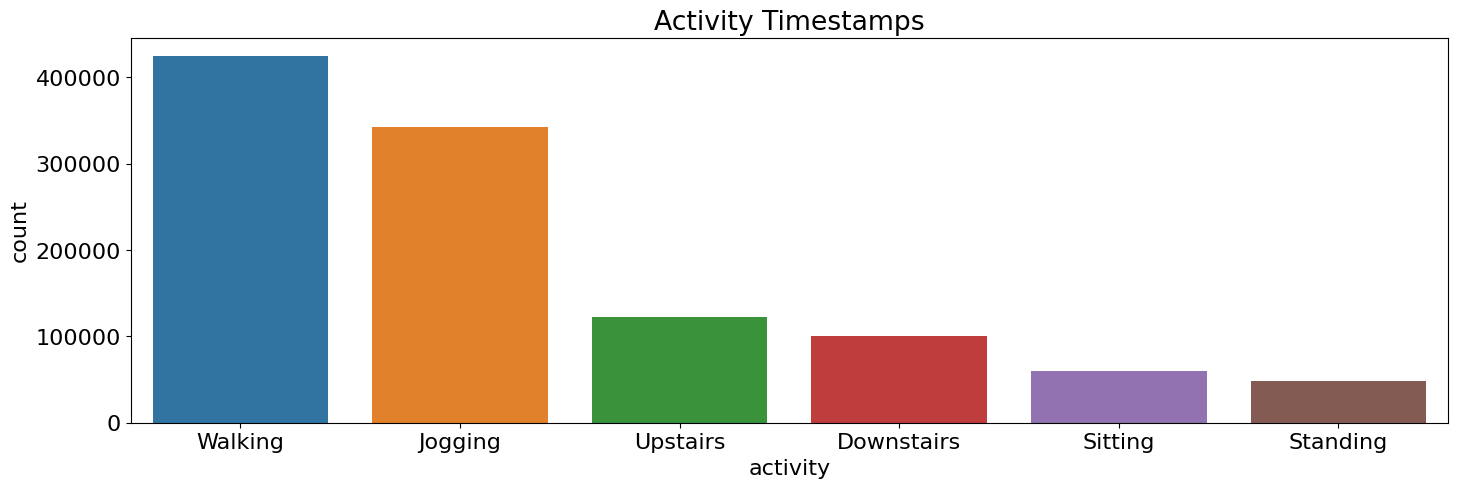

In [ ]:
# Inspect activities timestamps
plt.figure(figsize=(17,5))
sns.countplot(x = 'activity', data = df, order = df.activity.value_counts().index)
plt.title('Activity Timestamps')
plt.show()

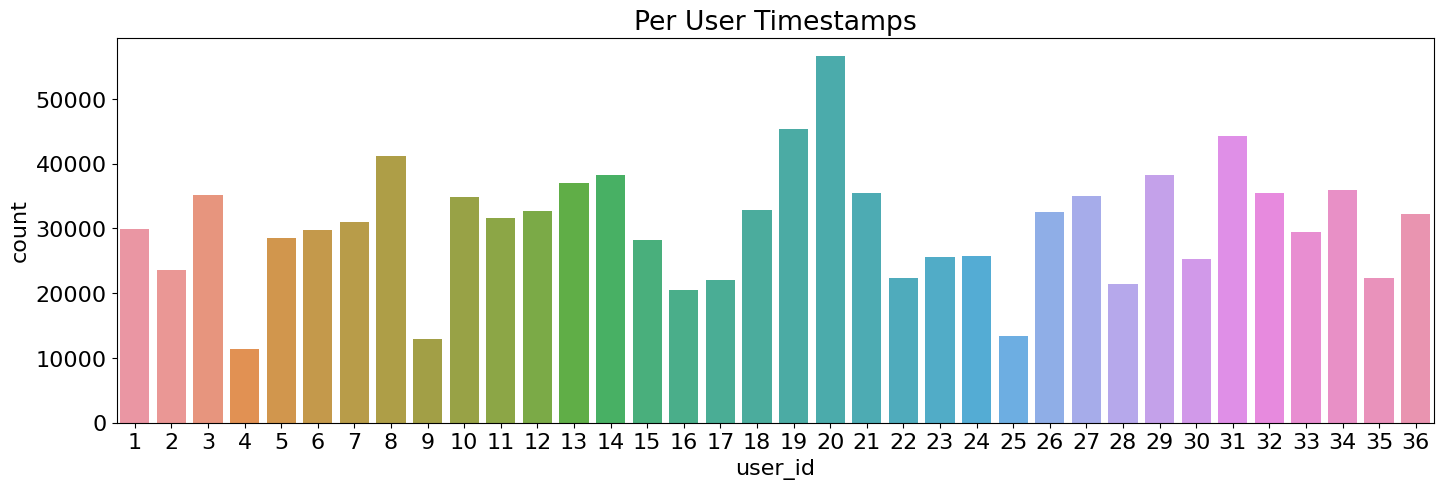

In [ ]:
# Inspect users timestamps
plt.figure(figsize=(17,5))
sns.countplot(x = 'user_id', data = df)
plt.title('Per User Timestamps')
plt.show()

In [ ]:
def inspect_activity(activity, df):
    data = df[df['activity'] == activity][['x_axis', 'y_axis', 'z_axis']][:500]
    axis = data.plot(subplots=True, figsize=(17, 9), title=activity)
    for ax in axis:
        ax.legend(loc='lower right')

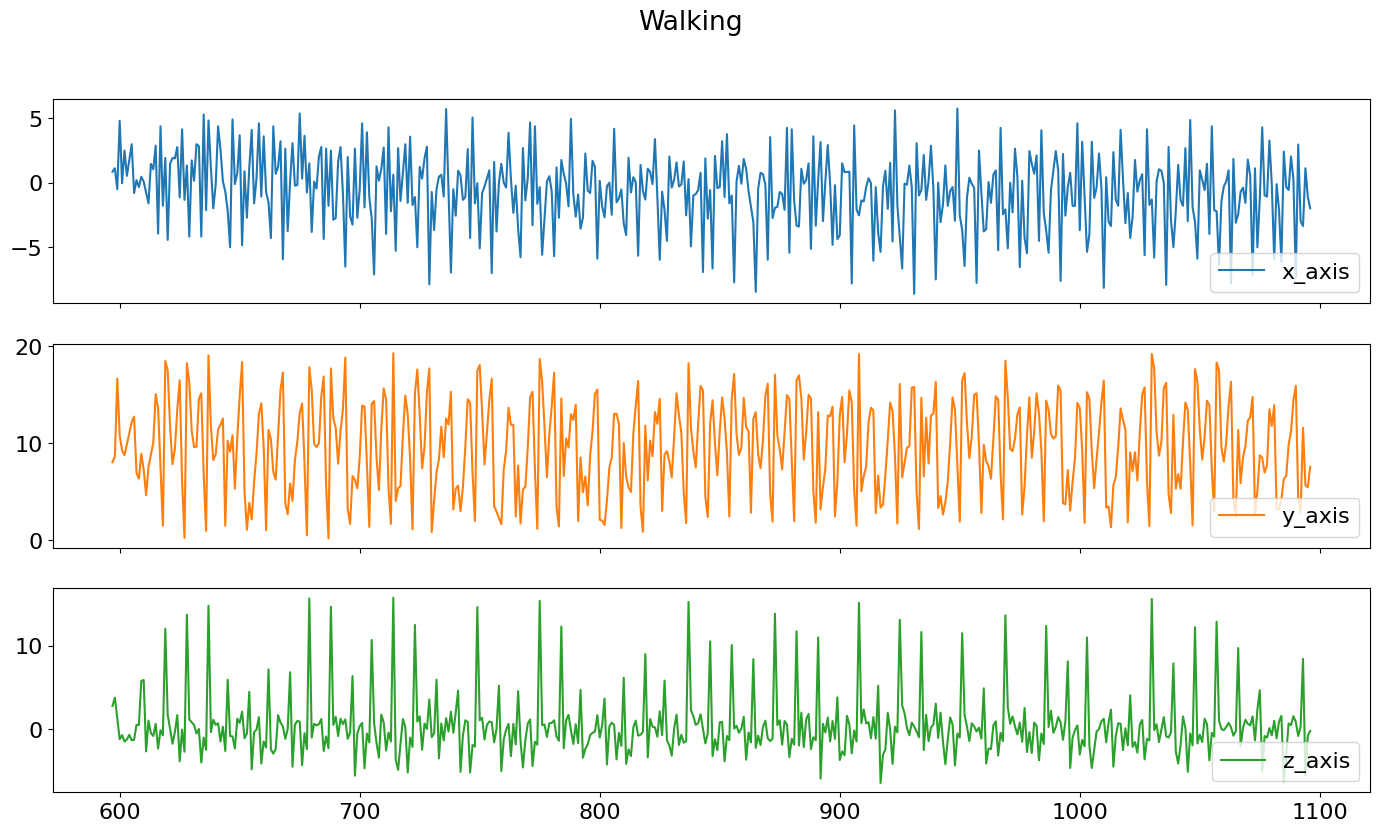

In [ ]:
inspect_activity("Walking", df)

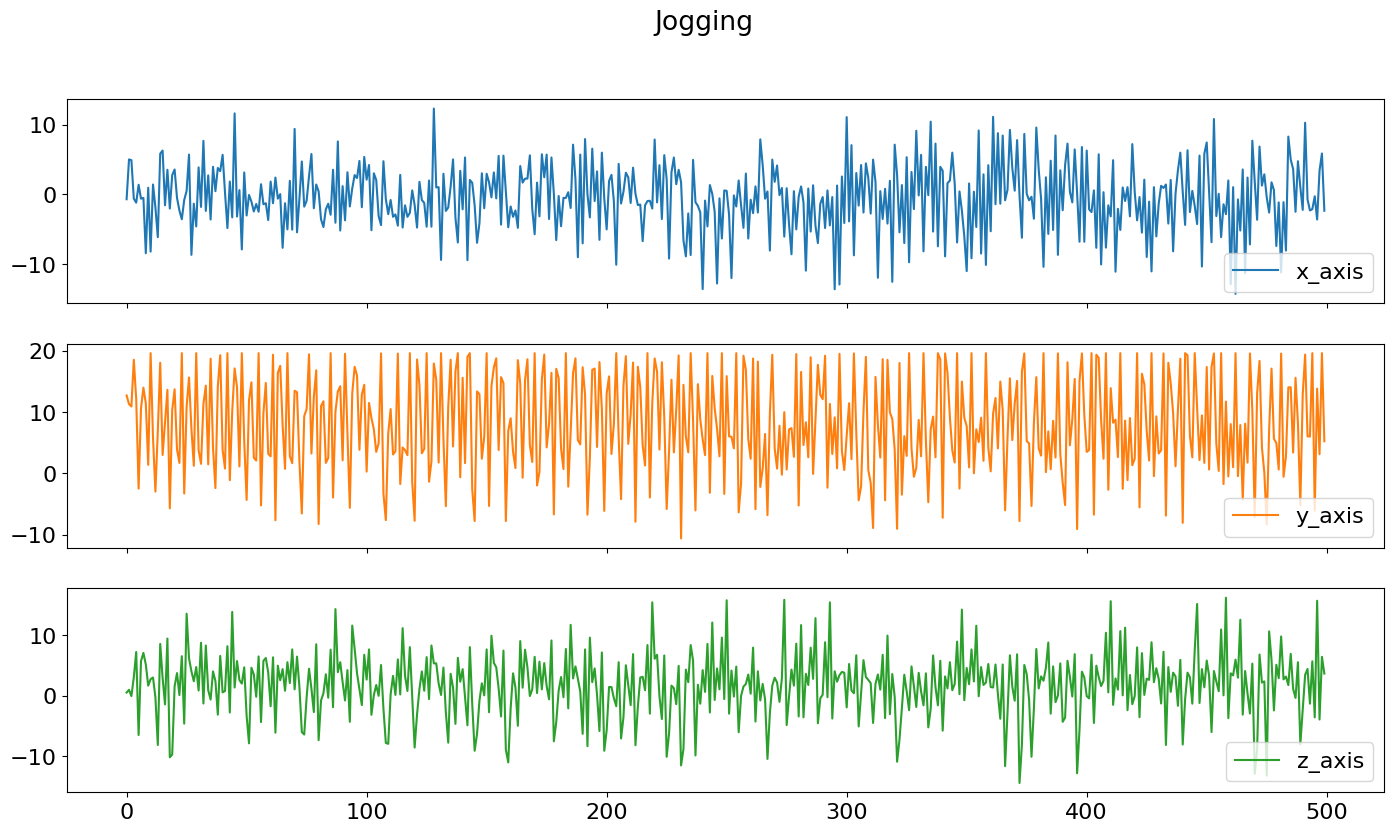

In [ ]:
inspect_activity("Jogging", df)

Preprocessing

The dataset is composed by 179 different activity executions


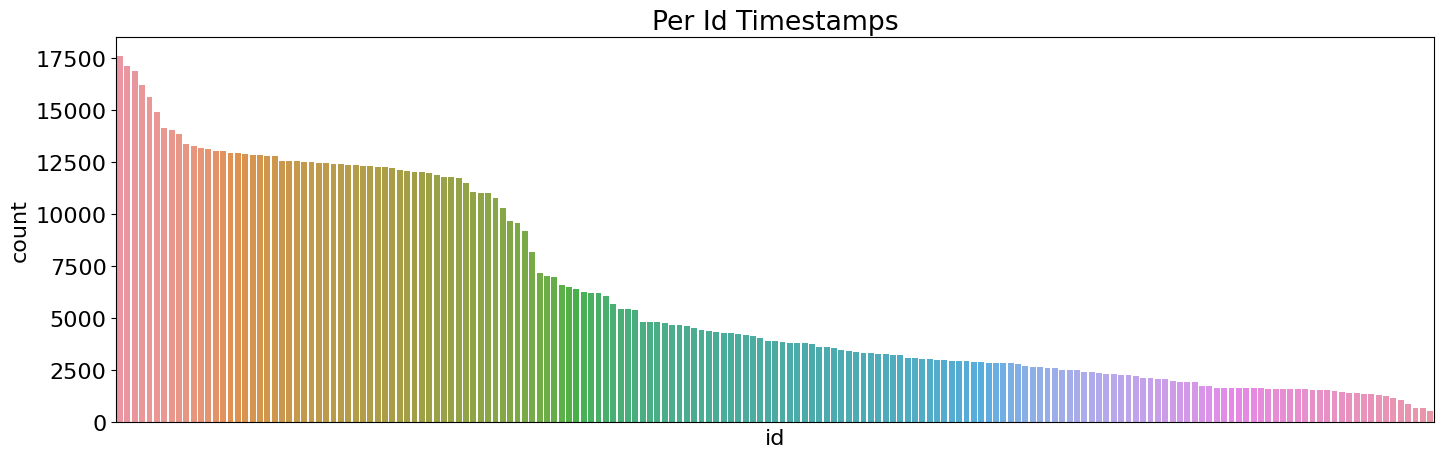

In [ ]:
# Identify single activities per user
df['id'] = df['user_id'].astype('str') + '_' + df['activity'].astype('str')
print('The dataset is composed by {} different activity executions'.format(df['id'].nunique()))

plt.figure(figsize=(17,5))
sns.countplot(x = 'id', data = df, order = df.id.value_counts().index)
plt.title('Per Id Timestamps')
plt.xticks([], [])
plt.show()

In [ ]:
df.head()

,user_id,activity,timestamp,x_axis,y_axis,z_axis,id
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953,33_Jogging
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424,33_Jogging
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722,33_Jogging
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717,33_Jogging
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164,33_Jogging


Split, Encode and Normalize

In [ ]:
# Split over users
df_train = df[df['user_id'] <= 30]
df_test = df[df['user_id'] > 30]
df_train.shape, df_test.shape

((898364, 7), (199844, 7))

In [ ]:
# Training users split
training_labels = {
    'Walking': 0,
    'Jogging': 0,
    'Upstairs': 0,
    'Downstairs': 0,
    'Sitting': 0,
    'Standing': 0
}
for id in df_train['id'].unique():
    label = df_train[df_train['id'] == id]['activity'].values[0]
    training_labels[label] += 1
print('Training labels:',training_labels)

Training labels: {'Walking': 30, 'Jogging': 26, 'Upstairs': 27, 'Downstairs': 27, 'Sitting': 17, 'Standing': 18}


In [ ]:
# Test users split
test_labels = {
    'Walking': 0,
    'Jogging': 0,
    'Upstairs': 0,
    'Downstairs': 0,
    'Sitting': 0,
    'Standing': 0
}
for id in df_test['id'].unique():
    label = df_test[df_test['id'] == id]['activity'].values[0]
    test_labels[label] += 1
print('Test labels:',test_labels)

Test labels: {'Walking': 6, 'Jogging': 6, 'Upstairs': 5, 'Downstairs': 5, 'Sitting': 6, 'Standing': 6}


In [ ]:
# Map activities to integers
label_mapping = {
    'Walking': 0,
    'Jogging': 1,
    'Upstairs': 2,
    'Downstairs': 3,
    'Sitting': 4,
    'Standing': 5
}

df_train['activity'] = df_train['activity'].map(label_mapping)
df_test['activity'] = df_test['activity'].map(label_mapping)

In [ ]:
# Apply MinMaxScaler to the useful features
scale_columns = ['x_axis', 'y_axis', 'z_axis']
scaler = MinMaxScaler()
scaler = scaler.fit(df_train[scale_columns])

df_train.loc[:, scale_columns] = scaler.transform(df_train[scale_columns].to_numpy())
df_test.loc[:, scale_columns] = scaler.transform(df_test[scale_columns].to_numpy())

In [ ]:
df_train.head()

,user_id,activity,timestamp,x_axis,y_axis,z_axis,id
8489,17,0,57869902574000,0.510163,0.741908,0.488932,17_Walking
8490,17,0,57870012316000,0.495703,0.751526,0.487895,17_Walking
8491,17,0,57870122301000,0.489850,0.742938,0.484785,17_Walking
8492,17,0,57870222246000,0.499490,0.748778,0.489623,17_Walking
8493,17,0,57870332292000,0.499490,0.750496,0.486858,17_Walking


In [ ]:
window = 200
stride = 50

In [ ]:
def build_sequences(df, window=200, stride=200):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    for id in df['id'].unique():
        # Take only meaningful features
        temp = df[df['id'] == id][['x_axis','y_axis','z_axis']].values
        # Save the label
        label = df[df['id'] == id]['activity'].values[0]
        # Compute padding length
        padding_len = window - len(temp)%window
        # Create padding and concatenate it
        padding = np.zeros((padding_len,3), dtype='float32')
        temp = np.concatenate((temp,padding))
        # Build features windows with their corresponging labels
        idx = 0
        while idx+window <= len(temp):
            dataset.append(temp[idx:idx+window])
            labels.append(label)
            idx += stride
    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [ ]:
X_train, y_train = build_sequences(df_train, window, stride)
X_test, y_test = build_sequences(df_test, window, stride)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((17841, 200, 3), (17841,), (3966, 200, 3), (3966,))

In [ ]:
# Convert the sparse labels to categorical values
y_train = tfk.utils.to_categorical(y_train)
y_test = tfk.utils.to_categorical(y_test)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((17841, 200, 3), (17841, 6), (3966, 200, 3), (3966, 6))

### Build and train models

In [ ]:
input_shape = X_train.shape[1:]
classes = y_train.shape[-1]
batch_size = 128
epochs = 200

#### Vanilla Long Short Term Memory (LSTM) Neural Network

![](https://drive.google.com/uc?export=view&id=1FZ_P4SgVAA_mCZQ0tK18VwRqGqzNANOE
)

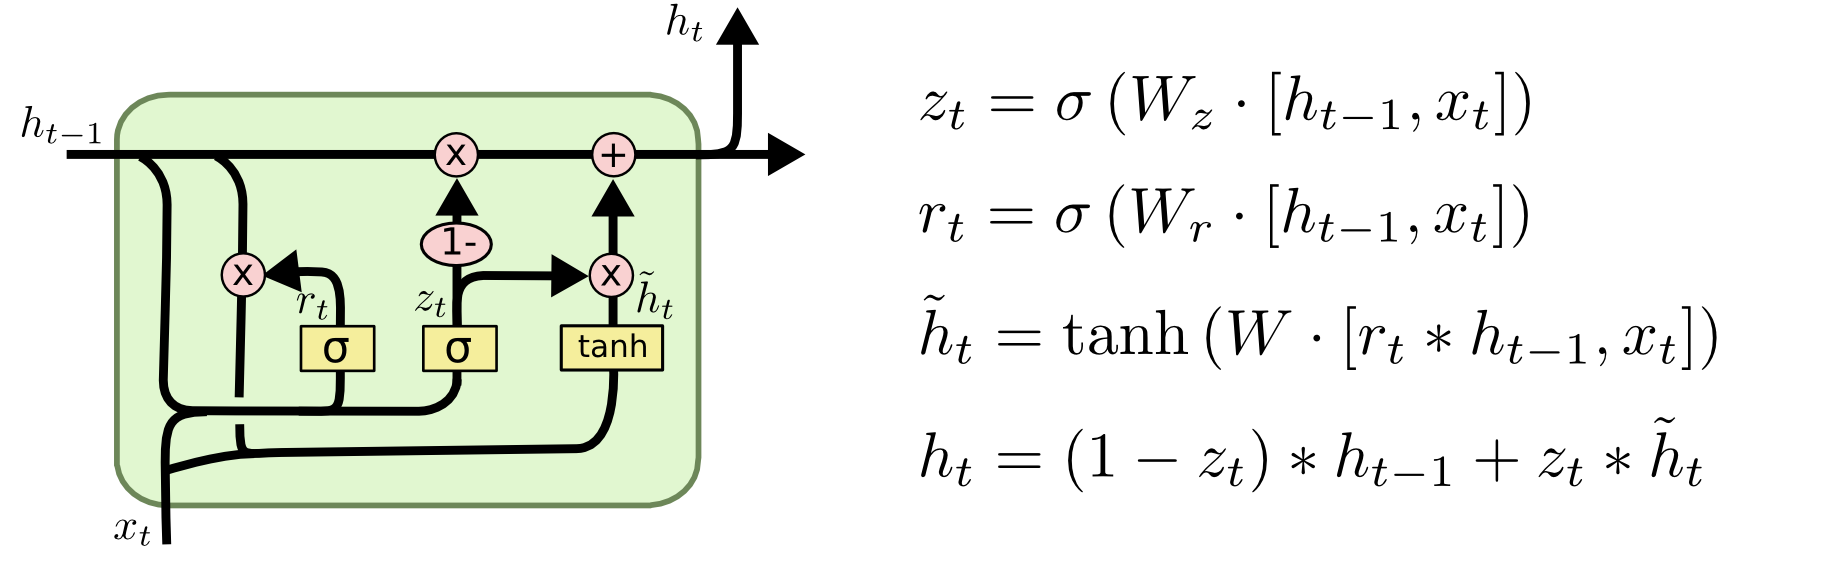

In [ ]:
def build_LSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    lstm = tfkl.LSTM(128, return_sequences=True)(input_layer)
    lstm = tfkl.LSTM(128)(lstm)
    dropout = tfkl.Dropout(.5, seed=seed)(lstm)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
model = build_LSTM_classifier(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 200, 3)]          0         
                                                                 
 lstm (LSTM)                 (None, 200, 128)          67584     
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                                 
Total params: 216454 (845.52 KB)
Trainable params: 216454 (84

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
126/126 [==============================] - 17s 60ms/step - loss: 1.4399 - accuracy: 0.4323 - val_loss: 1.2145 - val_accuracy: 0.6252 - lr: 0.0010
Epoch 2/200
126/126 [==============================] - 5s 37ms/step - loss: 1.3102 - accuracy: 0.4964 - val_loss: 1.2715 - val_accuracy: 0.5961 - lr: 0.0010
Epoch 3/200
126/126 [==============================] - 3s 28ms/step - loss: 1.2557 - accuracy: 0.5263 - val_loss: 1.1572 - val_accuracy: 0.6661 - lr: 0.0010
Epoch 4/200
126/126 [==============================] - 4s 29ms/step - loss: 1.2617 - accuracy: 0.5285 - val_loss: 1.1108 - val_accuracy: 0.6936 - lr: 0.0010
Epoch 5/200
126/126 [==============================] - 4s 30ms/step - loss: 1.2134 - accuracy: 0.5581 - val_loss: 1.0406 - val_accuracy: 0.6874 - lr: 0.0010
Epoch 6/200
126/126 [==============================] - 4s 29ms/step - loss: 1.1627 - accuracy: 0.5817 - val_loss: 1.1804 - val_accuracy: 0.5714 - lr: 0.0010
Epoch 7/200
126/126 [==============================] - 4s

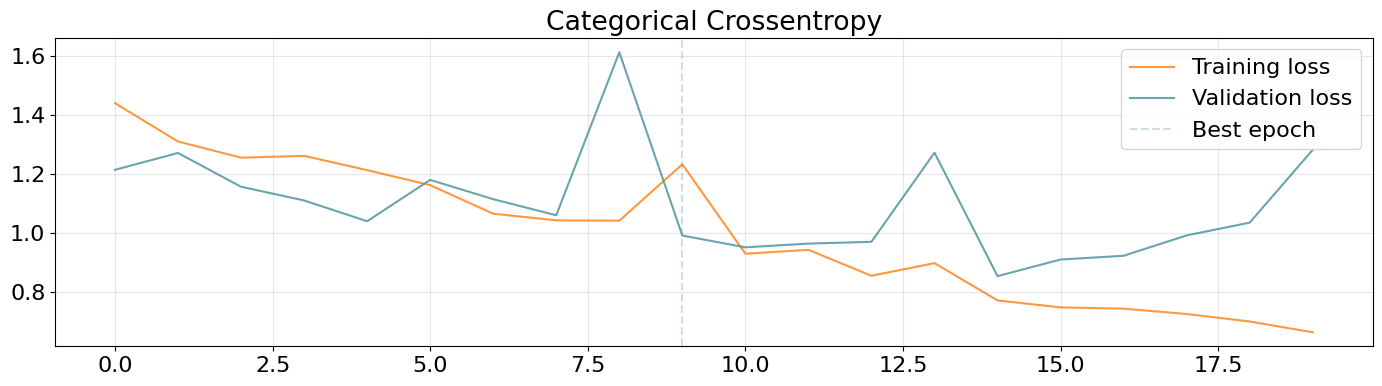

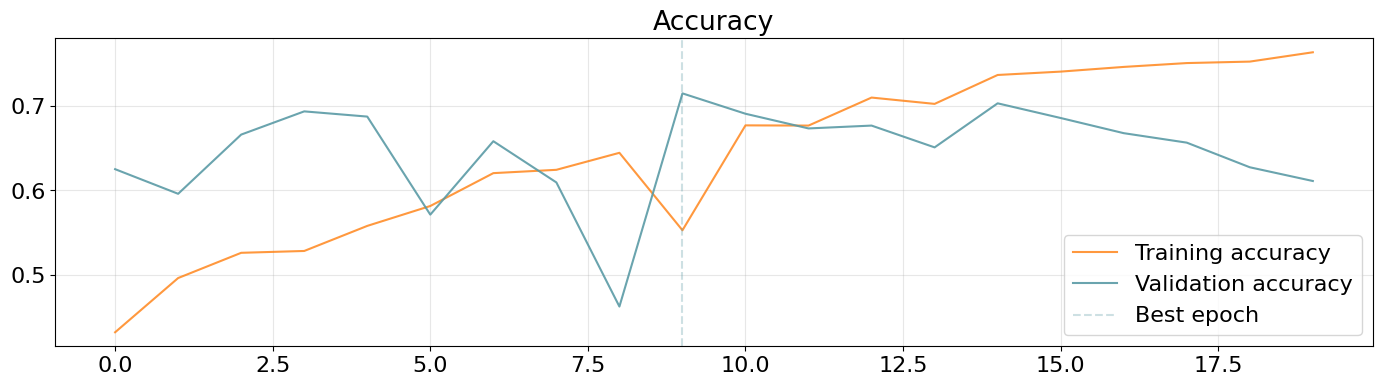

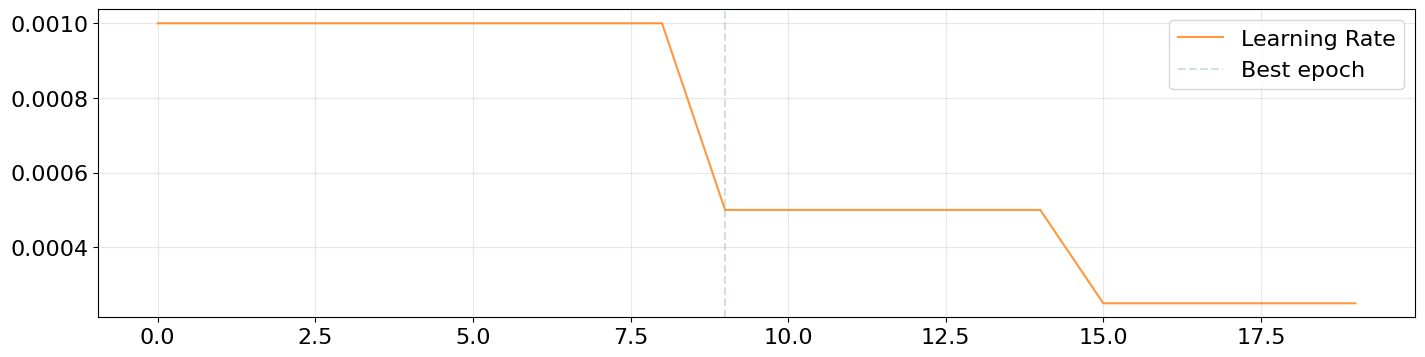

In [ ]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.save('LSTM')
model = tfk.models.load_model('LSTM')

In [ ]:
# Predict the test set with the LSTM
predictions = model.predict(X_test, verbose=0)
predictions.shape

(3966, 6)

Accuracy: 0.6077
Precision: 0.4576
Recall: 0.4248
F1: 0.4008


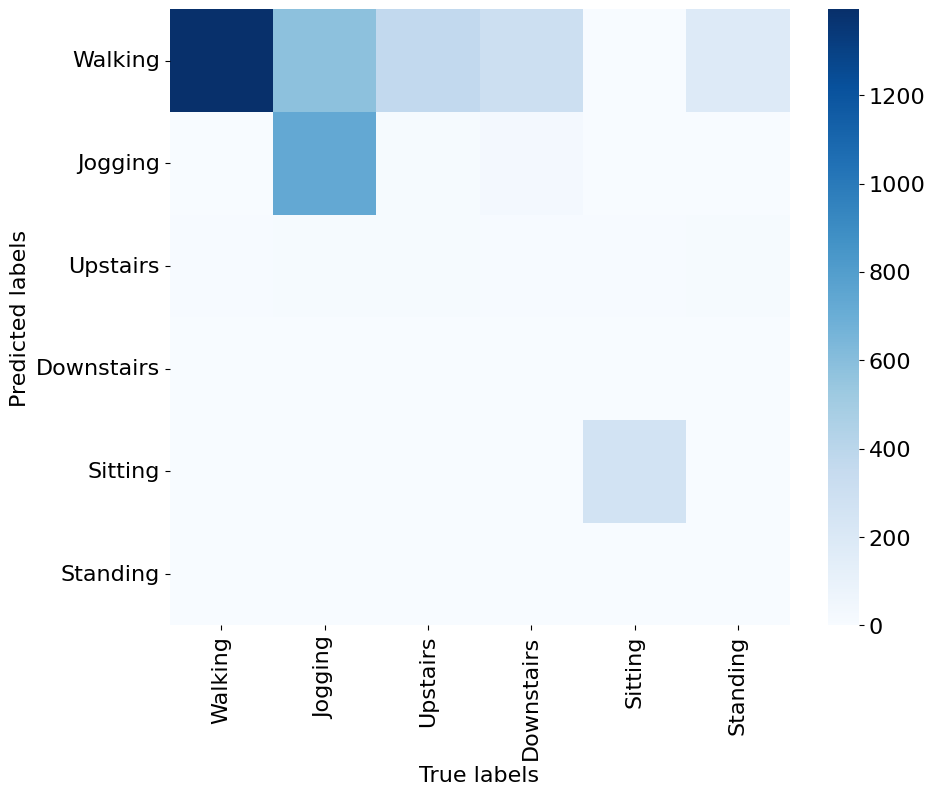

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

#### Bidirectional Long Short Term Memory (BiLSTM) Neural Network

![](https://drive.google.com/uc?export=view&id=1CN-jJqzb5AurhnMMiuvdVCaPGy2KReLc
)

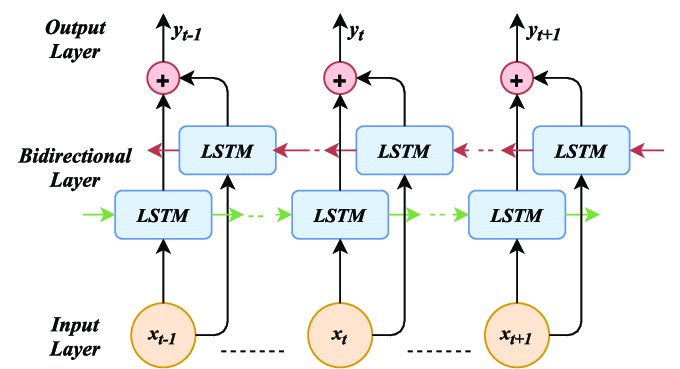

In [ ]:
def build_BiLSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(input_layer)
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128))(bilstm)
    dropout = tfkl.Dropout(.5, seed=seed)(bilstm)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
model = build_BiLSTM_classifier(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 200, 3)]          0         
                                                                 
 bidirectional (Bidirection  (None, 200, 256)          135168    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774   

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
126/126 [==============================] - 22s 91ms/step - loss: 1.3645 - accuracy: 0.4717 - val_loss: 1.1832 - val_accuracy: 0.5216 - lr: 0.0010
Epoch 2/200
126/126 [==============================] - 9s 71ms/step - loss: 1.2689 - accuracy: 0.5114 - val_loss: 1.0013 - val_accuracy: 0.6644 - lr: 0.0010
Epoch 3/200
126/126 [==============================] - 8s 62ms/step - loss: 1.1948 - accuracy: 0.5499 - val_loss: 1.1175 - val_accuracy: 0.6280 - lr: 0.0010
Epoch 4/200
126/126 [==============================] - 9s 70ms/step - loss: 1.2550 - accuracy: 0.5383 - val_loss: 1.1904 - val_accuracy: 0.4695 - lr: 0.0010
Epoch 5/200
126/126 [==============================] - 8s 64ms/step - loss: 1.3462 - accuracy: 0.4875 - val_loss: 1.4579 - val_accuracy: 0.3221 - lr: 0.0010
Epoch 6/200
126/126 [==============================] - 8s 64ms/step - loss: 1.4425 - accuracy: 0.4269 - val_loss: 1.2250 - val_accuracy: 0.6627 - lr: 0.0010
Epoch 7/200
126/126 [==============================] - 8s

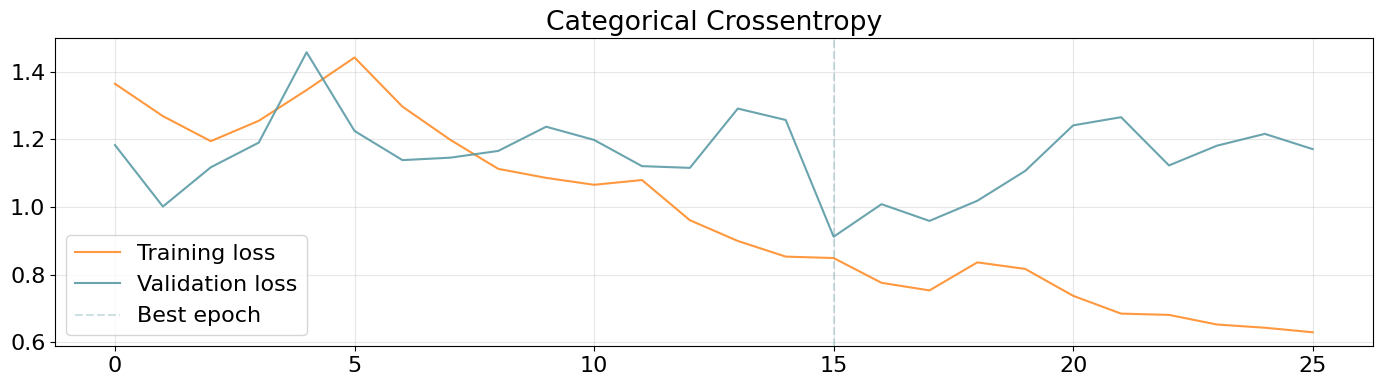

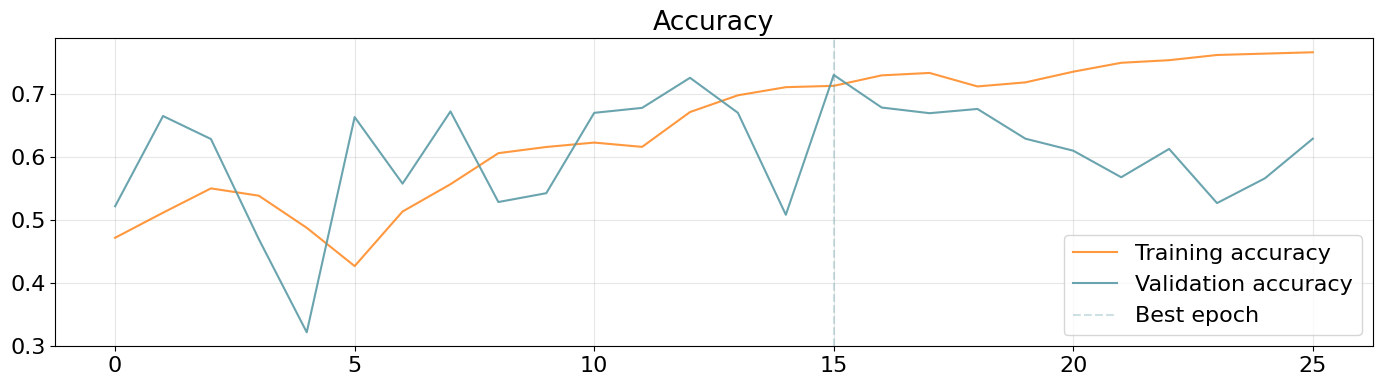

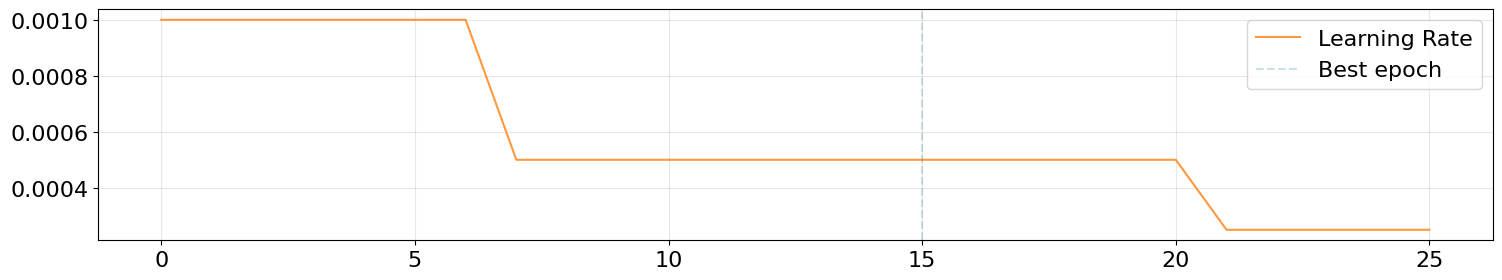

In [ ]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.save('BiLSTM')
model = tfk.models.load_model('BiLSTM')

In [ ]:
# Predict the test set with the BiLSTM
predictions = model.predict(X_test)
predictions.shape

124/124 [==============================] - 3s 13ms/step


(3966, 6)

Accuracy: 0.7063
Precision: 0.4405
Recall: 0.4638
F1: 0.4385


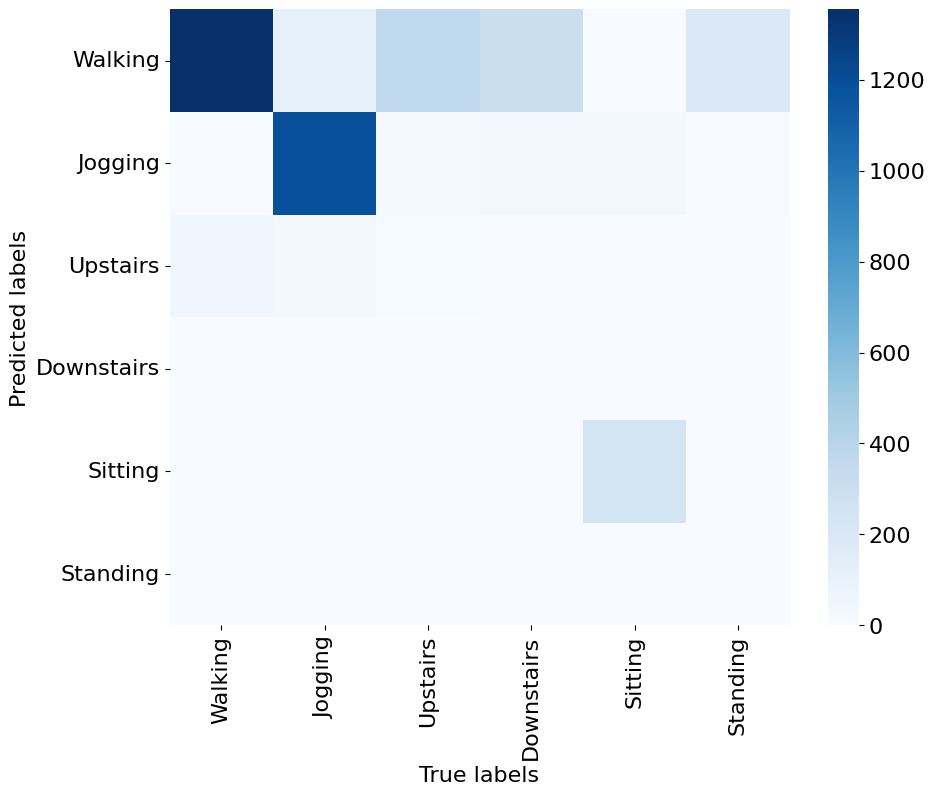

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

#### 1D Convolutional Neural Network

![](https://drive.google.com/uc?export=view&id=10B7c-F58-eNr6CP7D_UZeVp0gTeYMrFQ
)

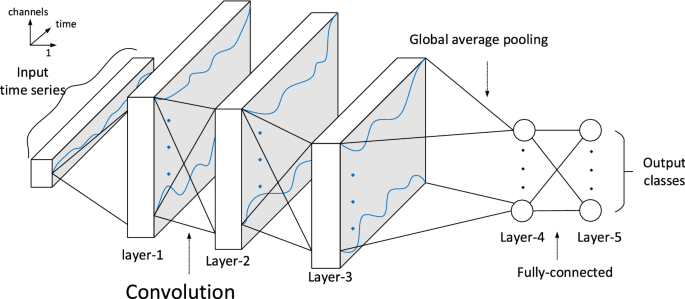

In [ ]:
def build_1DCNN_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    cnn = tfkl.Conv1D(128,3,padding='same',activation='relu')(input_layer)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(128,3,padding='same',activation='relu')(cnn)
    gap = tfkl.GlobalAveragePooling1D()(cnn)
    dropout = tfkl.Dropout(.5, seed=seed)(gap)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
model = build_1DCNN_classifier(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 200, 3)]          0         
                                                                 
 conv1d (Conv1D)             (None, 200, 128)          1280      
                                                                 
 max_pooling1d (MaxPooling1  (None, 100, 128)          0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 128)          49280     
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_2 (Dropout)         (None, 128)               0     

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
126/126 [==============================] - 8s 13ms/step - loss: 1.2632 - accuracy: 0.5395 - val_loss: 0.6963 - val_accuracy: 0.7625 - lr: 0.0010
Epoch 2/200
126/126 [==============================] - 1s 9ms/step - loss: 0.7604 - accuracy: 0.7340 - val_loss: 0.5013 - val_accuracy: 0.8504 - lr: 0.0010
Epoch 3/200
126/126 [==============================] - 1s 7ms/step - loss: 0.6272 - accuracy: 0.7703 - val_loss: 0.5152 - val_accuracy: 0.8448 - lr: 0.0010
Epoch 4/200
126/126 [==============================] - 1s 7ms/step - loss: 0.5788 - accuracy: 0.7788 - val_loss: 0.6829 - val_accuracy: 0.7742 - lr: 0.0010
Epoch 5/200
126/126 [==============================] - 1s 7ms/step - loss: 0.5451 - accuracy: 0.7894 - val_loss: 0.5077 - val_accuracy: 0.8174 - lr: 0.0010
Epoch 6/200
126/126 [==============================] - 1s 7ms/step - loss: 0.5266 - accuracy: 0.7933 - val_loss: 0.4824 - val_accuracy: 0.8168 - lr: 0.0010
Epoch 7/200
126/126 [==============================] - 1s 7ms/s

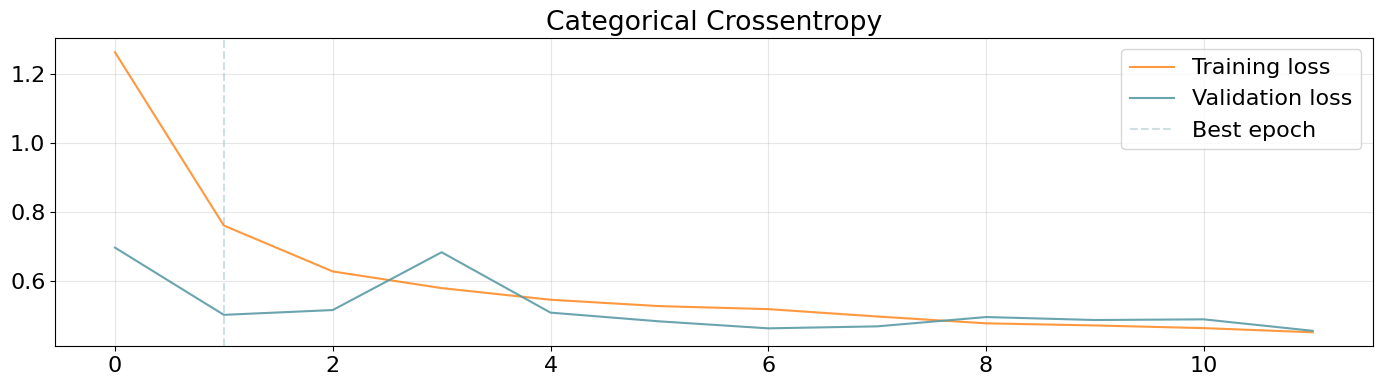

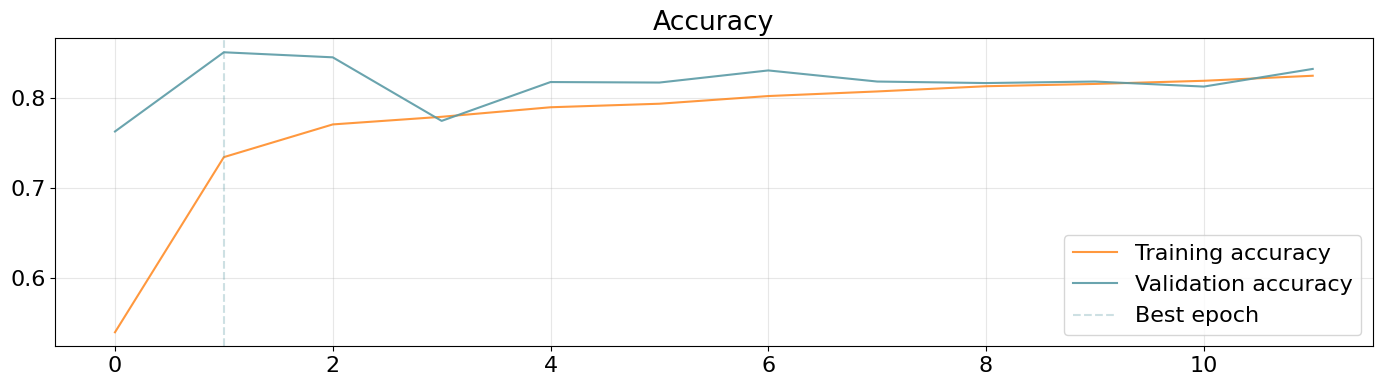

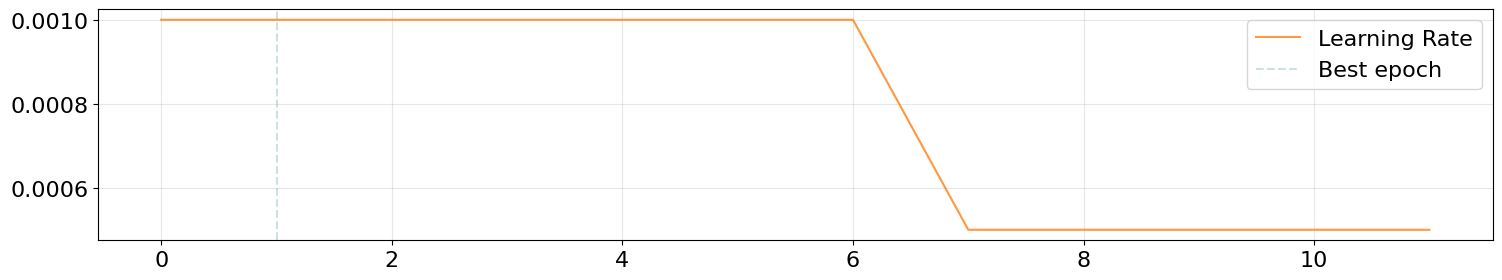

In [ ]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.save('1DCNN')
model = tfk.models.load_model('1DCNN')

In [ ]:
# Predict the test set with the 1DCNN
predictions = model.predict(X_test)
predictions.shape

124/124 [==============================] - 1s 3ms/step


(3966, 6)

Accuracy: 0.8003
Precision: 0.7076
Recall: 0.6494
F1: 0.6301


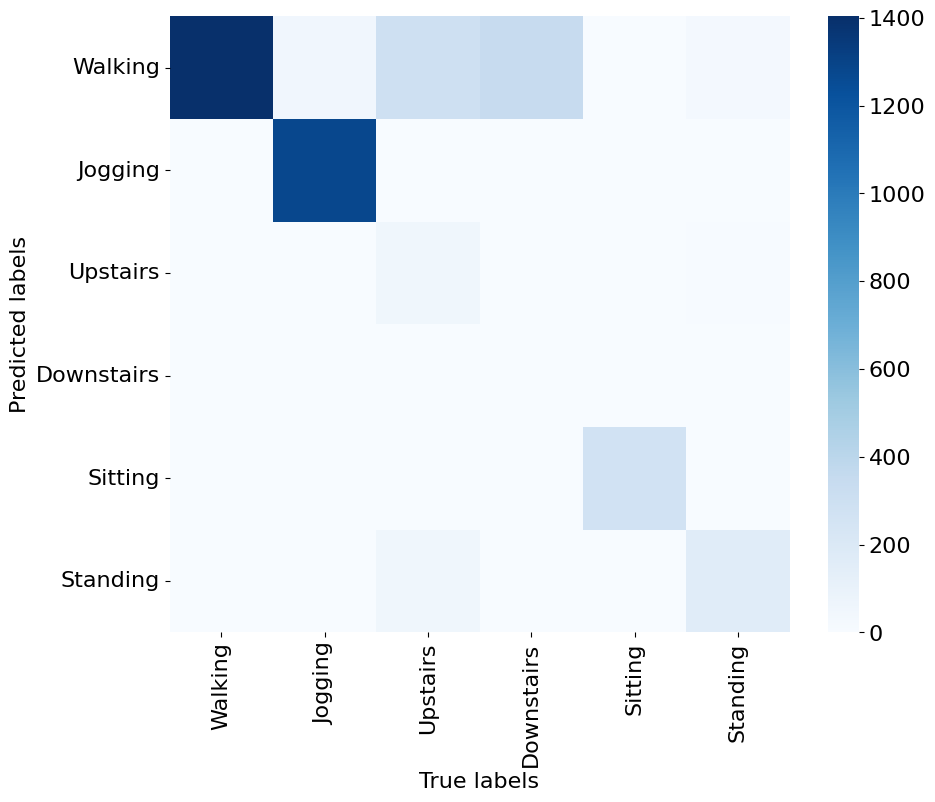

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

*Credits: Eugenio Lomurno, 📧 eugenio.lomurno@polimi.it*